In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext Cython

# Cell below for bosons

In [12]:
%%cython
cimport cython
from libc.stdlib cimport malloc, free
from libc.math cimport sqrt
from cython cimport sizeof
from itertools import combinations_with_replacement


import numpy as np
cimport numpy as np


ctypedef struct bstate:
    int* state
    int size
    double norm_const

    
cdef void free_bosons(bstate in_state) nogil:
    free(in_state.state)

cdef print_state(bstate instate):
    for i in range(instate.size):
        print(instate.state[i], end=" ")
    print("\nstate sites =",instate.size,"\nnorm constant in front of state =",instate.norm_const)
    
    


@cython.boundscheck(False)
@cython.wraparound(False)
cdef int factorial(int a) nogil:
    if a == 0:
        return 1
    cdef int result, i
    result = 1
    for i in range(a):
        result = result*(i+1)
    return result
    

cdef int bosonic_basis_size(int bosons, int sites) nogil:
    if (bosons<0) or (sites<0):
        raise ValueError("negative sites or occupations")
    cdef int result
    result = (factorial(bosons+sites-1))//(factorial(bosons)*factorial(sites-1))
    return result

@cython.boundscheck(False)
@cython.wraparound(False)
cdef bstate* ordered_basis(int bosons, int sites):
    # Generate all possible combinations of site occupations with replacement
    combinations = list(combinations_with_replacement(range(sites), bosons))

    # Sort the combinations in lexicographic order
    combinations = sorted(combinations)
    cdef int length = len(combinations)

    # Create basis vectors from the sorted combinations
    cdef bstate* basis_vectors = <bstate*>malloc(length*sizeof(bstate))
    
    cdef int i
    for i in range(length):
        basis_vectors[i] = create_bosons("0" * sites, sites)  # Initialize with all zeros
        
        for site in combinations[i]:
            basis_vectors[i].state[site] += 1
            #basis_vectors[i].norm_const = sqrt(<double>basis_vectors[i].state[site]) needed ???? check theory books
    return basis_vectors


@cython.boundscheck(False)
@cython.wraparound(False)
cdef bstate create_bosons(str state, int space_size) nogil:
    cdef int* state_array = <int*>malloc(space_size*sizeof(int))
    if state_array is NULL:
        raise MemoryError("Failed to allocate memory for state_array")
    
    for i in range(space_size):
        if state[i] < 0:
            raise ValueError("no negative occupation numbers for bosonic states")
        state_array[i] = <int>state[i]-48 #minus 48 because of ascii encoding from str to int. 0 is 48 in ascii. 1 is 49
    cdef bstate result
    result.state = state_array
    result.size = space_size
    result.norm_const = 1
    return result

    
cdef bstate apply_creator(bstate in_state, int site) nogil:
    #index = site-1
    cdef bstate result
    result = in_state
    result.state[site-1] = in_state.state[site-1]+1
    result.norm_const = sqrt(<double>result.state[site-1])
    return result

cdef bstate apply_annahilator(bstate in_state, int site) nogil:
    #index = site-1
    cdef bstate result
    result = in_state
    result.state[site-1] = in_state.state[site-1]-1

    #if result.state[site-1]+1 == 0:
    #    result.norm_const = 0.
    #else:
    result.norm_const = sqrt(<double>(result.state[site-1]+1))
    return result


cdef bint compare_states(bstate state1, bstate state2) nogil:
    if state1.size != state2.size:
        raise ValueError("states have different number of sites. direct comparison may be illogical")
    cdef int i
    cdef bint token
    for i in range(state1.size):
        if state1.state[i] != state2.state[i]:
            return 0
    return 1

cdef double contract_states(bstate state1, bstate state2) nogil:
    if compare_states(state1, state2):
        return state1.norm_const * state2.norm_const

    
    

cpdef no_interaction_boson_gas(int bosons, int sites, double eta):
    cdef int h_size = bosonic_basis_size(bosons, sites)
    cdef bstate* basis = ordered_basis(bosons, sites)
    cdef bstate tmp_state
    cdef int i, j, k
    
    Matrix = np.zeros((h_size, h_size))
    
    for i in range(h_size):
        for j in range(h_size):
            for k in range(sites):
                Matrix[i][j] = \
                Matrix[i][j] +\
                contract_states(basis[i], (apply_creator((apply_annahilator(basis[j], (k+2)%sites)), (k+1)%sites))) +\
                contract_states(basis[i], (apply_annahilator((apply_creator(basis[j], (k+2)%sites)), (k+1)%sites)))
                
    for i in range(h_size):
        free_bosons(basis[i])
    free(basis)
    return Matrix

    
    

    

cdef int state_size = 4
cdef bstate test1 = create_bosons("2100", state_size)


print_state(test1)




cdef double ann = contract_states(test1, apply_annahilator(test1, 3))
print(ann)
#print_state(ann)





free_bosons(test1)


2 1 0 0 
state sites = 4 
norm constant in front of state = 1.0
0.0


In [5]:
import matplotlib.pyplot as plt

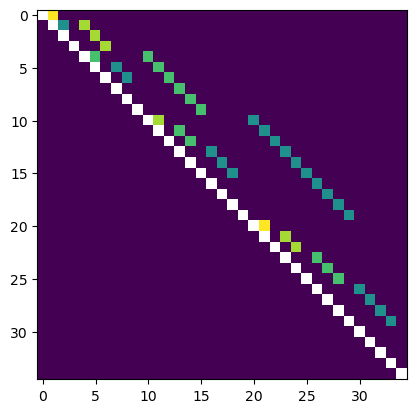

In [13]:
ham = no_interaction_boson_gas(4, 4, 1)

plt.imshow(ham)

In [ ]:
ham[0,0]

# Cell below for fermions
## Progress in te fermions basis is slow. The bosons Code cell further down is more complete. It uses mostly abstraction with structs while the fermionic cell tried (unsuccessfully still) to use the more explicit vector representations. Problems still lie in the coding aspect

In [ ]:
%%cython
cimport cython
from libc.stdlib cimport malloc, free
from cython cimport sizeof
#import numpy as np
#cimport numpy as np



ctypedef struct f_state:
    int* state
    int size

cdef void free_fermions(f_state fstate) nogil:
    free(fstate.state)

@cython.boundscheck(False)
@cython.wraparound(False)
cdef f_state create_fermions(str state, int space_size):
    cdef int* state_array = <int*>malloc(space_size*sizeof(int))
    if state_array is NULL:
        raise MemoryError("Failed to allocate memory for state_array")
    
    for i in range(space_size):
        if state[i] not in ('0', '1'):
            raise ValueError("spinless fermion states can only have 1 occupation or none 0")
        state_array[i] = <int>state[i]-48 #minus 48 because of ascii encoding from str to int. 0 is 48 in ascii. 1 is 49
    cdef f_state fstate
    fstate.state = state_array
    fstate.size = space_size
    return fstate


@cython.boundscheck(False)
@cython.wraparound(False)
cdef int* create_explicit_fermions(f_state in_state):
    cdef int total_size = 2**in_state.size
    cdef int tmp_dimension
    cdef int index
    if in_state.state[0] == 0:
        index = 0
    elif in_state.state[0] == 1:
        index = 1
    if (in_state.size > 1):
        for i in range(in_state.size):
            tmp_dimension = 2**(i+1)
            if (in_state.state[i+1] == 0):
                index = index
            elif (in_state.state[i+1] == 1):
                index = index + tmp_dimension
    cdef int* result = <int*>malloc(total_size*sizeof(int))
    for i in range(total_size):
        result[i] = 0
    result[index] = 1
    return result

    

@cython.boundscheck(False)
@cython.wraparound(False)
cdef int* apply_creator(int k, f_state ket):
    cdef f_state tmp_ket = ket
    cdef int* tmp_ket_explicit
    cdef int const1 = (1-ket.state[k-1])
    cdef int i,j
    for i in range(k-1):
        if ket.state[i] == 1:
            const1 = -const1
    tmp_ket.state[k] = 1
    tmp_ket_explicit = create_explicit_fermions(tmp_ket)
    for j in range(2**tmp_ket.size):
        tmp_ket_explicit[j] = const1*tmp_ket_explicit[j]
    return tmp_ket_explicit
    
        
    





#test unit 2

cdef str fermions = "1110"
cdef int fsize = len(fermions)

print("\nthe state in dirac notation")
cdef f_state fermion_state = create_fermions(fermions, fsize)
for i in range(fsize):
    print(fermion_state.state[i], end=" ")

print("\nthe state in an explicit Fock space vector\n")
cdef int* fermion_vector = create_explicit_fermions(fermion_state)
for i in range(2**fsize):
    print(fermion_vector[i])

    
print("\nNow we want to apply the creator to our 1110 state and get the 1111 state out\n")
cdef str fermions2 = "1111"
cdef int fsize2 = len(fermions2)
cdef f_state fermion2_state = create_fermions(fermions2, fsize2)

cdef int* fermion2_vector = apply_creator(4, fermion_state)
print("\nafter application, the explicit vector looks like this\n")
for i in range(2**fsize):
    print(fermion2_vector[i])

    
print("\nlet's construct the vector explicitly from the state\n")
cdef int* proof = create_explicit_fermions(fermion2_state)
for i in range(2**fsize):
    print(proof[i])
free_fermions(fermion_state)
free(fermion_vector)
free_fermions(fermion2_state)
free(fermion2_vector)
free(proof)


